In [104]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


In [63]:
x = np.random.randn(64,5)
y = np.sin(np.sum(x, axis=1, keepdims=True))


In [155]:
class NonLin_Regressor:
   
    def __init__(self, ind, outd, optr="Ada") -> None:


        self.w = np.ones((ind, 3))
        self.wg = None
        self.recordw = None

        self.act = lambda x:np.maximum(0, x)
        self.actg = None

        self.w1 = np.ones((3,outd))
        self.w1g = None
        self.recordw1 = None

        self.lossg = None

        self.optr = optr

    def forward(self, x:np.ndarray)->np.ndarray:
        
        self.wg = x.T 
        s1 = x@self.w ##Linear1
        s1 = normalize(s1, axis=0) 
        
        self.actg =(s1>0).astype(np.float32)
        x1 =  self.act(s1) ## Relu1
        
        self.w1g = x1.T
        x2 = x1@self.w1 ##Linear2
        
        return x2
    
    def train(self, x:np.ndarray, y:np.ndarray, lr=0.001 ,epoch=5)->np.ndarray:
        print(self.optr)
        print()
        l = np.ones(epoch)*np.inf
        for e in tqdm(range(epoch)):
            
            yhat = self.forward(x)
            loss = self.mse(yhat=yhat, y = y)
            l[e] = (float(loss))

            g1, g = self.__backward()
            self.__step(lr=lr, g=g, g1=g1)

        return l
    
    def __backward(self)->tuple:
        
        chain = self.lossg
        g1 = (self.w1g@chain)    
        chain = self.actg*(chain@self.w1.T)
        g = self.wg@chain

        return g1, g

    def __step(self, lr=0.01, g1=None, g=None)->None:
        
        gupdate = lr*g
        g1update = lr*g1
        
        if self.optr== "SGD":
            pass
        
        elif self.optr == "momentum":
            
            if self.recordw is not None:
                gupdate += 0.9*self.recordw
                g1update += 0.9*self.recordw1

            else :
                self.recordw = gupdate.copy()
                self.recordw1 = g1update.copy()

        elif self.optr == "Ada":
            
            if self.recordw is not None:
                
                gupdate /= (self.recordw+1e-10)**0.5
                g1update /= (self.recordw1+1e-10)**0.5
                
                self.recordw1 += g1**2
                self.recordw += g**2

            else :
                self.recordw = g**2
                self.recordw1 = g1**2
        
       
        self.w -= gupdate
        self.w1 -= g1update
    
    def mse(self, yhat:np.ndarray, y:np.ndarray)->np.float32:
        self.lossg = (yhat-y)/y.shape[0]
        return np.mean(0.5*((yhat-y)**2))
    

SGD



100%|██████████| 1000/1000 [00:00<00:00, 12820.23it/s]


momentum



100%|██████████| 1000/1000 [00:00<00:00, 14493.65it/s]


Ada



100%|██████████| 1000/1000 [00:00<00:00, 14777.68it/s]


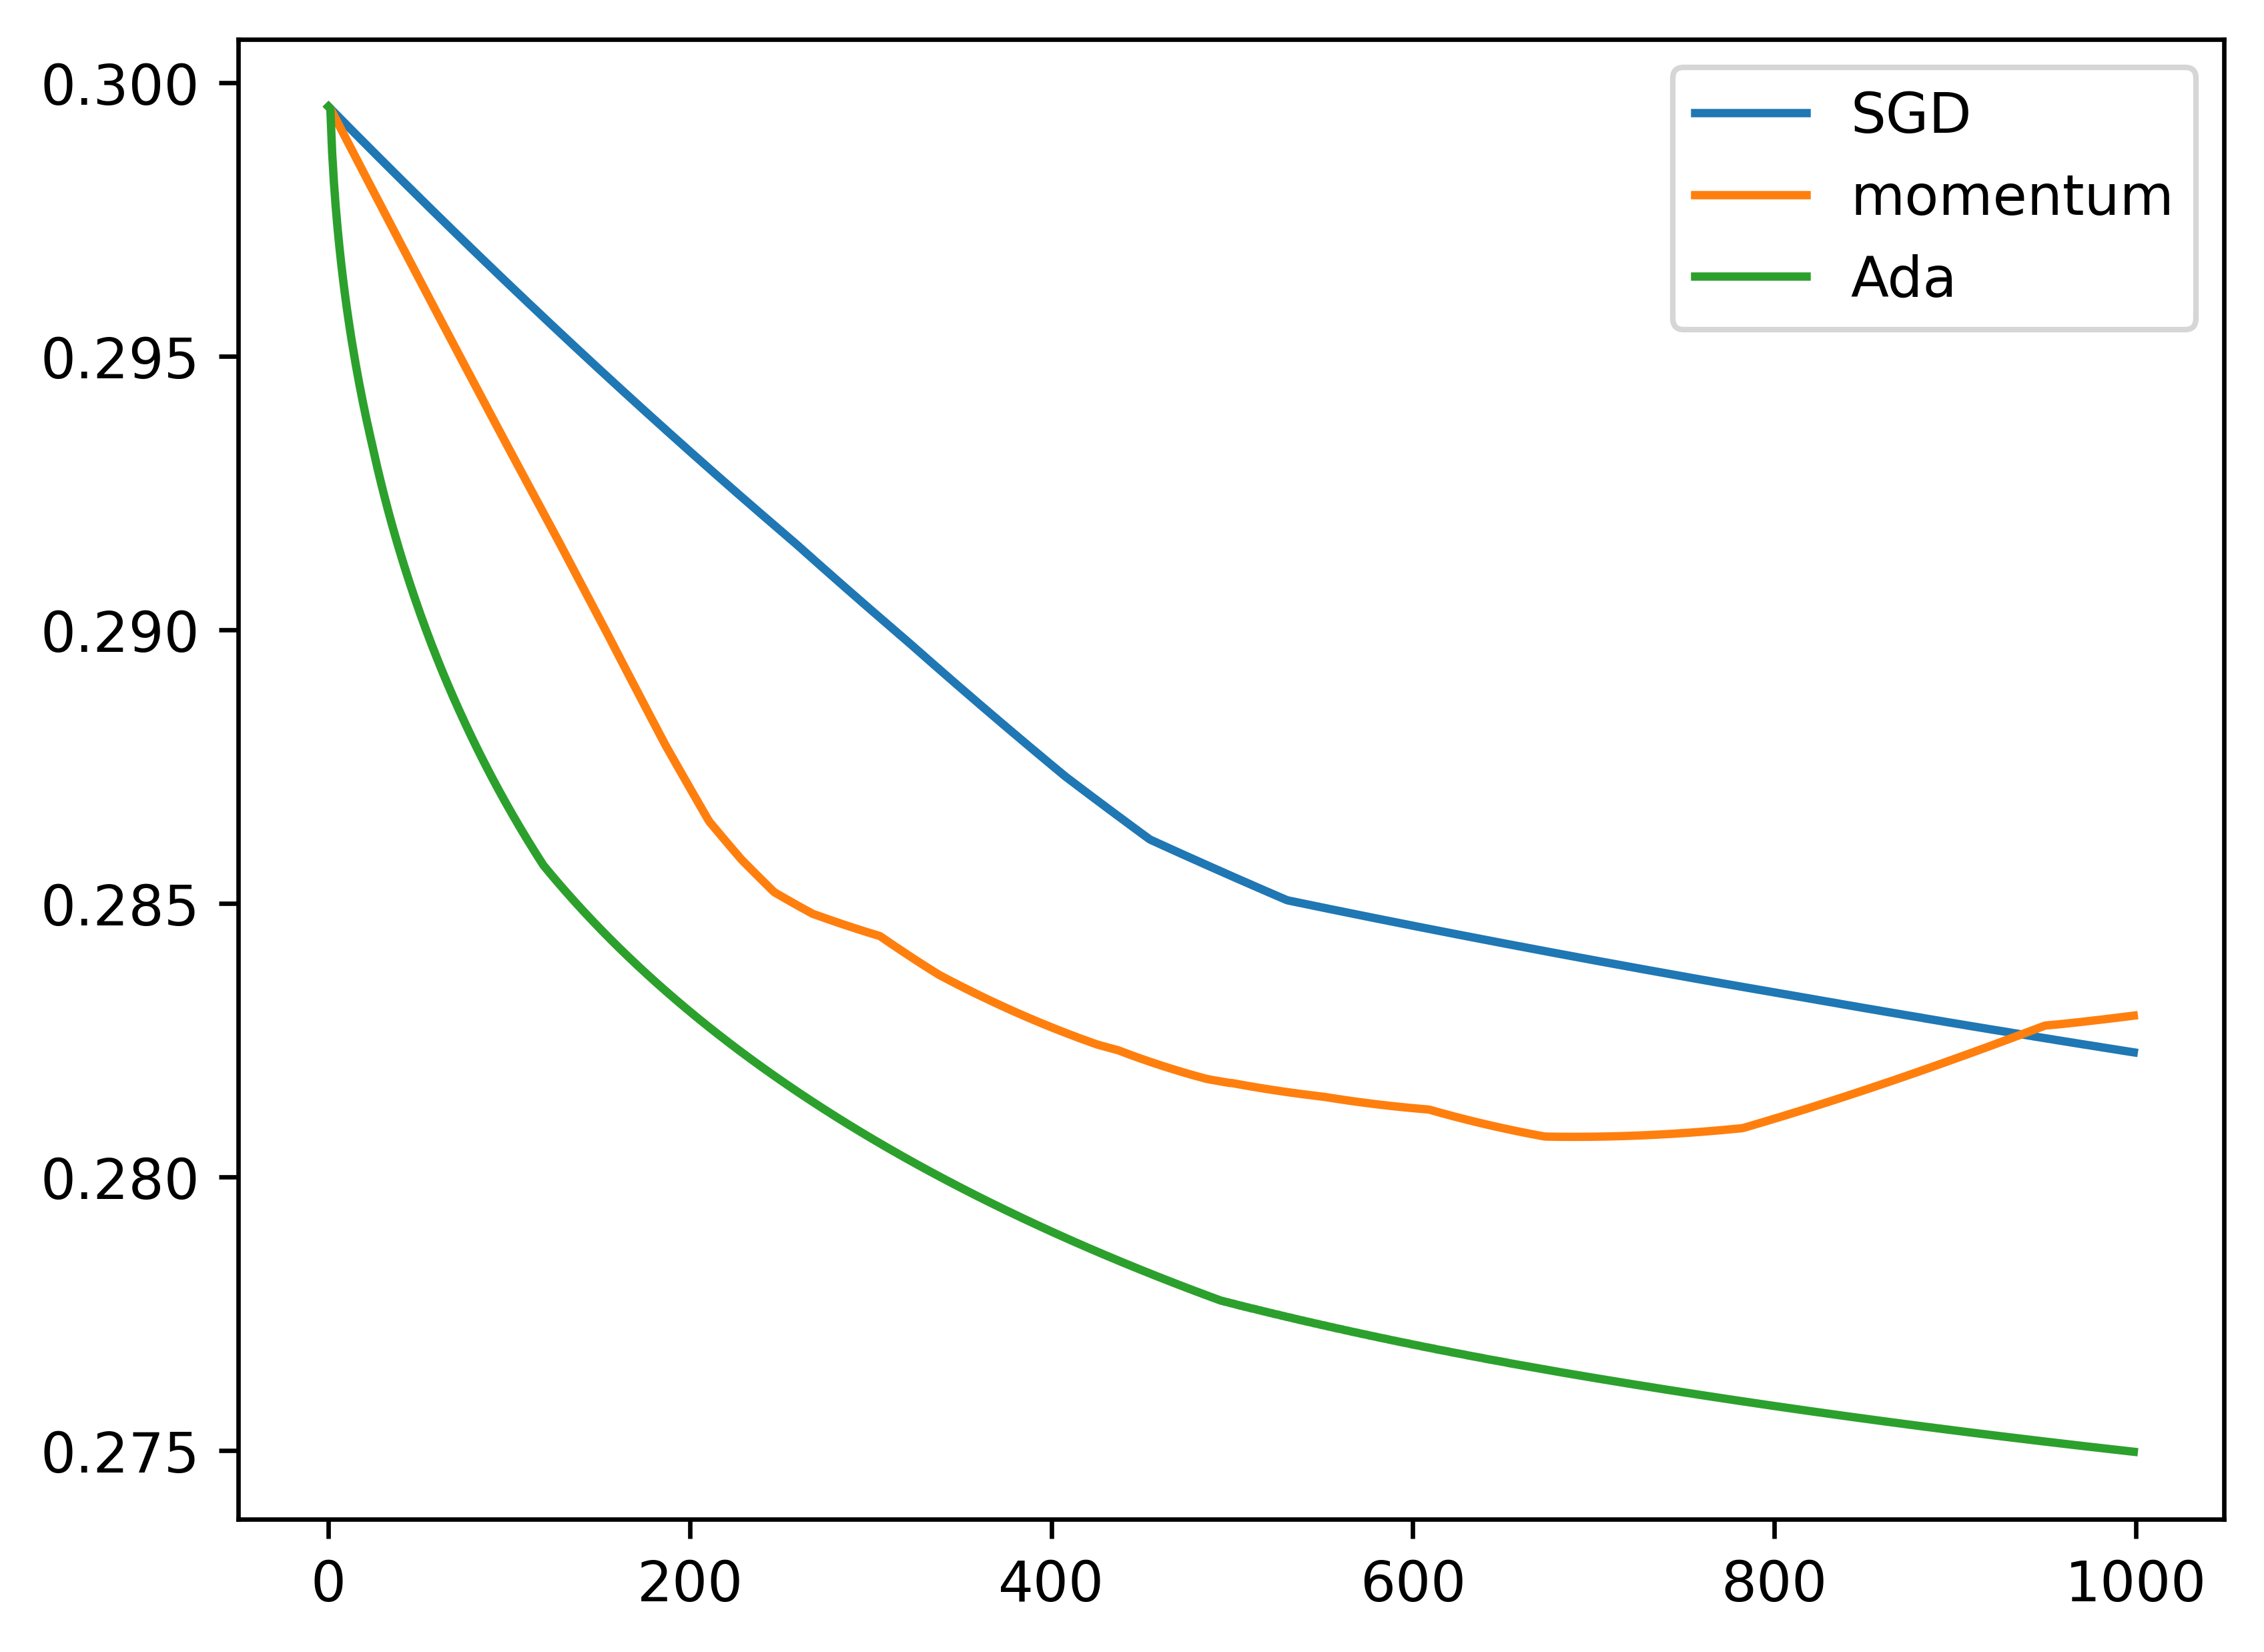

In [157]:
epochs = 1000; lr = 0.01

Rsgd = NonLin_Regressor(ind=5, outd=1, optr="SGD")
sgdL = Rsgd.train(x=x, y=y, epoch=epochs, lr=lr)

Rmom = NonLin_Regressor(ind=5, outd=1, optr="momentum")
momL = Rmom.train(x=x, y=y, epoch=epochs, lr=lr)

Rada = NonLin_Regressor(ind=5, outd=1, optr="Ada")
adaL = Rada.train(x=x, y=y, epoch=epochs, lr=lr)


e = np.arange(epochs)
plt.figure(dpi=600)
plt.plot(e, sgdL, label="SGD")
plt.plot(e, momL, label="momentum")
plt.plot(e, adaL, label="Ada")
plt.legend()
plt.show()
